In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject
import copy
import functools
import itertools

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
from numpy import ndarray
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState
from progressbar import progressbar as pbar
from enum import Enum
import re
from enum import Enum
from matplotlib import patches

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses
from tensorflow.keras import layers

from cnn_segm import keras_custom_loss

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    VolumeCropSequence, MetaCrop3DGenerator, VSConstantEverywhere, 
    GTConstantEverywhere, SequentialGridPosition, ET3DConstantEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg.data import EstimationVolume
from tomo2seg import AggregationStrategy

# Setup

In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-4-cf972d05bc84>:<module>:004}::[2020-11-22::20:07:36.262]
runid=1606072056



In [5]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
logger.debug(f"{strategy=}")

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:001}::[2020-11-22::20:07:36.310]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:002}::[2020-11-22::20:07:36.312]
Num GPUs Available: 0
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:003}::[2020-11-22::20:07:36.344]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[]
tf.config.list_logical_devices('GPU')=[]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:011}::[2020-11-22::20:07:36.350]
strategy=<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f907c72baf0>



# Options

In [6]:
# this will later be useful when i transform this in python script
save_probas_by_class = True

debug__save_figs = True
debug__materialize_crops = False
debug__save_processed_crops = False
probabilities_dtype = np.float16

# Model

In [7]:
ls ../data/models | grep unet-2d-small

unet-2d-small.vanilla00.000.1605-971-456.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-972-712/
unet-2d-small.vanilla00.000.1605-972-712.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-982-196/
unet-2d-small.vanilla00.000.1605-982-196.autosaved.hdf5


In [8]:
tomo2seg_model = Tomo2SegModel.build_from_model_name(
    "unet-2d-small.vanilla00.000.1605-982-196"
)
logger.info(f"{tomo2seg_model=}")

with strategy.scope():
    model = tf.keras.models.load_model(
        tomo2seg_model.autosaved_model_path_str,
        compile=False
    )
    
    in_ = model.layers[0]
    in_shape = in_.input_shape[0]
    input_n_channels = in_shape[-1:]

    logger.debug(f"{input_n_channels=}")
    
    # make it capable of getting any dimension in the input
    anysize_input = layers.Input(
        shape=[None, None, None] + list(input_n_channels),
        name="input_any_image_size"
    )
    
    logger.debug(f"{anysize_input=}")
    
    model.layers[0] = anysize_input
    
    # todo keep this somewhere instead of copying and pasting
    optimizer = optimizers.Adam()
    loss_func = keras_custom_loss.jaccard2_loss

    model.compile(loss=loss_func, optimizer=optimizer)


INFO::tomo2seg::{<ipython-input-8-d7942cfb89c4>:<module>:004}::[2020-11-22::20:07:36.638]
tomo2seg_model=Model(master_name='unet-2d-small', version='vanilla00', fold=0, runid=1605982196, factory_function=None, factory_kwargs=None)

DEBUG::tomo2seg::{<ipython-input-8-d7942cfb89c4>:<module>:016}::[2020-11-22::20:07:38.633]
input_n_channels=(1,)

DEBUG::tomo2seg::{<ipython-input-8-d7942cfb89c4>:<module>:024}::[2020-11-22::20:07:38.636]
anysize_input=<tf.Tensor 'input_any_image_size:0' shape=(None, None, None, None, 1) dtype=float32>



# Data

In [9]:
from tomo2seg.datasets import (
#     VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-9-cdb1781c8ebd>:<module>:010}::[2020-11-22::20:07:38.712]
volume_name='PA66GF30' volume_version='v1-reduced' labels_version='refined3'



In [10]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)
voldata_test = volume.test_partition.get_volume_partition(voldata)

del voldata
logger.debug(f"{voldata_train.shape=} {voldata_val.shape=} {voldata_test.shape=}")

DEBUG::tomo2seg::{data.py:with_check:227}::[2020-11-22::20:07:38.765]
vol=Volume(name='PA66GF30', version='v1-reduced', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:245}::[2020-11-22::20:07:38.767]
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.labels.raw

Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.weights.raw

DEBUG::tomo2seg::{data.py:metadata:184}::[2020-11-22::20:07:38.768]
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.metadata.yml`.

INFO::tomo2seg::{<ipython-input-10-127f893db5f4>:<module>:007}::[2020-11-22::20:07:38.776]
volume=Volume(name='PA66GF30', version='v1-reduced', _metadata=Volume.Metadata(dimensions=[256, 256, 256], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 256], 'y_range': [0, 256], 'z_range': [0, 128], 'alias

# Crop generator (not yet integrated)

# Estimation Volume

In [11]:
# data_volume = voldata_train
# partition = volume.train_partition

# data_volume = voldata_val
# partition = volume.val_partition

data_volume = voldata_test
partition = volume.test_partition

agg_strategy = AggregationStrategy.average_probabilities

logger.debug(f"{data_volume.shape=} {partition=} {agg_strategy=} {runid=}")

DEBUG::tomo2seg::{<ipython-input-11-a4286ac1c483>:<module>:012}::[2020-11-22::20:07:38.958]
data_volume.shape=(256, 256, 64) partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(192, 256), alias='test') agg_strategy=<AggregationStrategy.average_probabilities: 0> runid=1606072056



In [12]:
estimation_volume = EstimationVolume.from_objects(
    volume=volume, 
    model=tomo2seg_model, 
    set_partition=partition,
    runid=runid,
)
estimation_volume["aggregation_strategy"] = agg_strategy.name

logger.info(f"{estimation_volume=}")

DEBUG::tomo2seg::{data.py:metadata_path:290}::[2020-11-22::20:07:39.025]
Creating metadata file /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.metadata.yml.

DEBUG::tomo2seg::{data.py:__setitem__:298}::[2020-11-22::20:07:39.027]
Writing to file self.metadata_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.metadata.yml').

INFO::tomo2seg::{<ipython-input-12-ccaae396c38c>:<module>:009}::[2020-11-22::20:07:39.031]
estimation_volume=EstimationVolume(volume_fullname='PA66GF30.v1-reduced', model_name='unet-2d-small.vanilla00.000.1605-982-196', runid=1606072056, partition=SetPartition(x_range=(0

# Processing

In [13]:
if debug__save_figs:
    figs_dir = estimation_volume.dir
    logger.debug(f"{figs_dir=}")
    figs_dir.mkdir(exist_ok=True)

DEBUG::tomo2seg::{<ipython-input-13-18204e9a3117>:<module>:003}::[2020-11-22::20:07:39.085]
figs_dir=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056')



# Shapes and steps 

In [14]:
# it has to be multiple of 16 because of the 4 cascaded 2x2-strided 2x2-downsamplings in u-net
xy_dims_multiple_16 = [int(16 * np.floor(dim / 16)) for dim in volume.metadata.dimensions[:2]]
logger.debug(f"{xy_dims_multiple_16=}")

crop_shape = tuple(xy_dims_multiple_16 + [1])  # x-axis, y-axis, z-axis
volume_shape = data_volume.shape

logger.debug(f"{crop_shape=}   {volume_shape=}")

n_steps = tuple(
    int(np.ceil(vol_dim / crop_dim))
    for vol_dim, crop_dim in zip(volume_shape, crop_shape)
)
logger.debug(f"{n_steps=}")

def get_coordinates_iterator(n_steps_):
    assert len(n_steps_) == 3
    return itertools.product(*(range(n_steps_[dim]) for dim in range(3)))

get_ijk_iterator = functools.partial(
    get_coordinates_iterator, copy.copy(n_steps)
)

get_kji_iterator = functools.partial(
    get_coordinates_iterator, tuple(reversed(n_steps))
)

# coordinates (xs, ys, and zs) of the front upper left corners of the crops
x0s, y0s, z0s = tuple(
    tuple(map(
        int, 
        np.linspace(0, vol_dim - crop_dim, n)
    ))
    for vol_dim, crop_dim, n in zip(volume_shape, crop_shape, n_steps)
)
logger.debug(f"""{min(x0s)=}, {max(x0s)=}, {len(x0s)=}
{min(y0s)=}, {max(y0s)=}, {len(y0s)=}
{min(z0s)=}, {max(z0s)=}, {len(z0s)=}
""")

DEBUG::tomo2seg::{<ipython-input-14-0d701cd4dcc5>:<module>:003}::[2020-11-22::20:07:39.151]
xy_dims_multiple_16=[256, 256]

DEBUG::tomo2seg::{<ipython-input-14-0d701cd4dcc5>:<module>:008}::[2020-11-22::20:07:39.153]
crop_shape=(256, 256, 1)   volume_shape=(256, 256, 64)

DEBUG::tomo2seg::{<ipython-input-14-0d701cd4dcc5>:<module>:014}::[2020-11-22::20:07:39.157]
n_steps=(1, 1, 64)

DEBUG::tomo2seg::{<ipython-input-14-0d701cd4dcc5>:<module>:036}::[2020-11-22::20:07:39.159]
min(x0s)=0, max(x0s)=0, len(x0s)=1
min(y0s)=0, max(y0s)=0, len(y0s)=1
min(z0s)=0, max(z0s)=63, len(z0s)=64




# Orthogonal slices figs

In [15]:
from tomo2seg import viz

INFO::tomo2seg::{<ipython-input-16-e2dd832f70ce>:<module>:011}::[2020-11-22::20:07:39.522]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.orthogonal-slices-display.x=128-y=128-z=32.png'



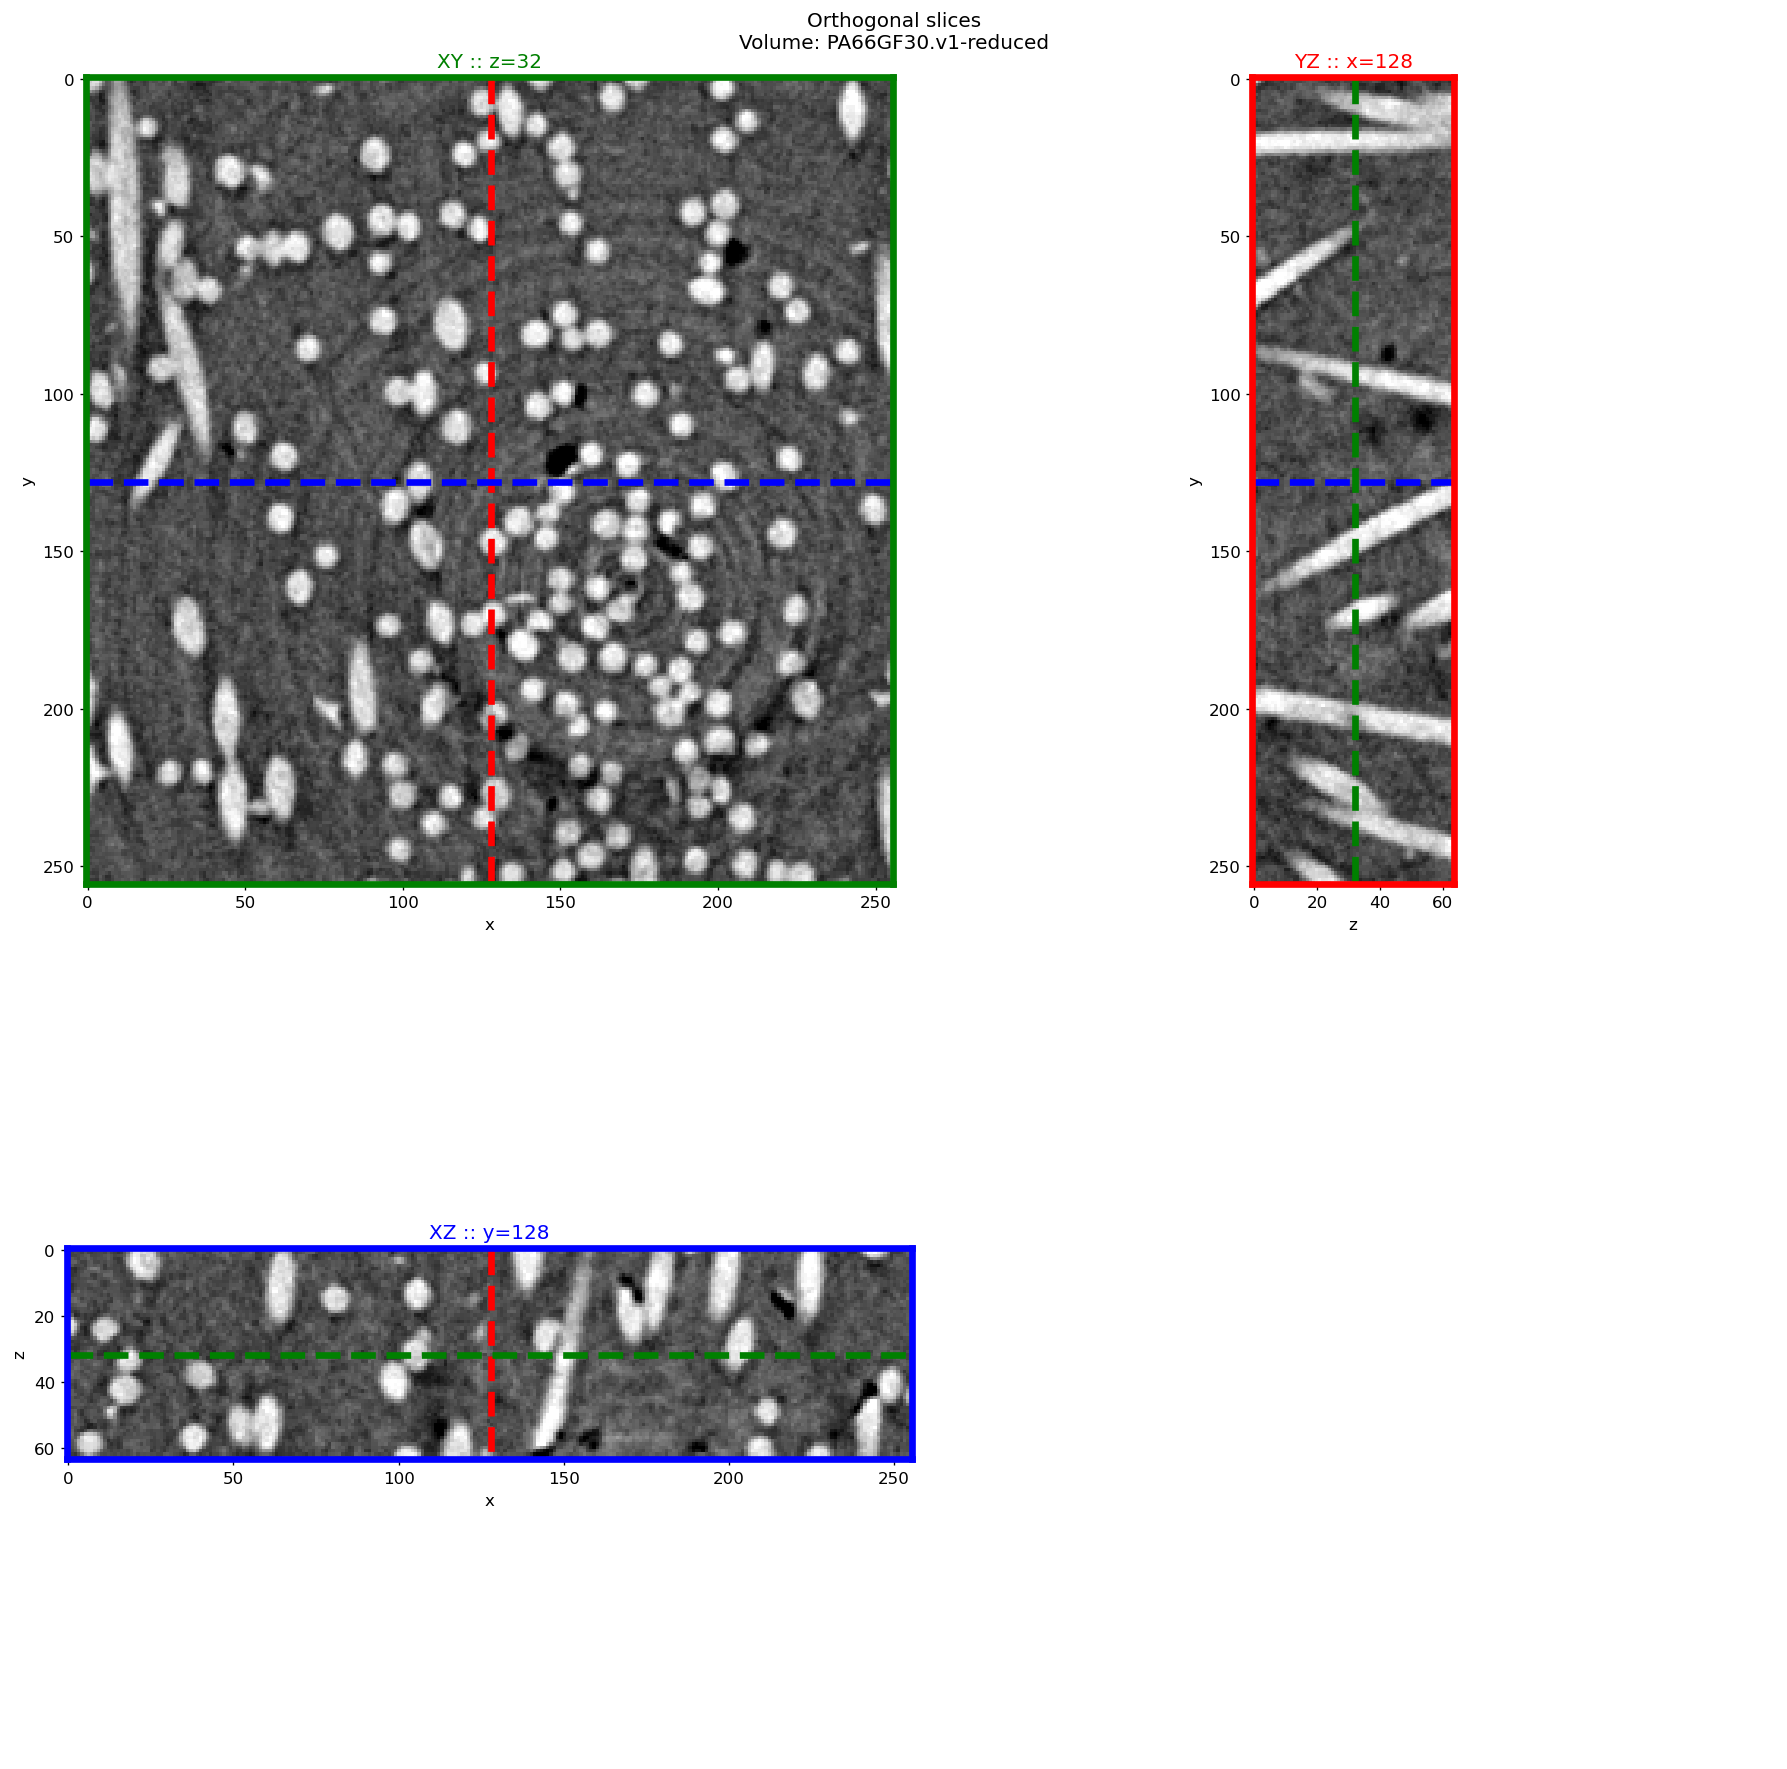

In [16]:
if debug__save_figs:
    
    fig, axs = plt.subplots(2, 2, figsize=(sz := 15, sz), dpi=120)
    fig.set_tight_layout(True)
    
    display = viz.OrthogonalSlicesDisplay(
        volume=data_volume,
        volume_name=volume.fullname,
    ).plot(axs=axs,)
    
    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        dpi=200, format="png",
        metadata=display.metadata,
    )    

# Crops coordinates 

In [17]:
logger.debug("Generating the crop coordinates.")

crops_coordinates = np.array(
    [
        (
            (x0, x0 + crop_shape[0]), 
            (y0, y0 + crop_shape[1]),
            (z0, z0 + crop_shape[2]),
        )
        for x0, y0, z0 in itertools.product(x0s, y0s, z0s)
    ], 
    dtype=tuple
).reshape(len(x0s), len(y0s), len(z0s), 3, 2).astype(int)  # 3 = nb of dimenstions, 2 = (start, end)

logger.debug(f"{crops_coordinates.shape=}\n{crops_coordinates[0, 0, 0]=} ")

# 'F' reshapes with x varying fastest and z slowest
crops_coordinates_sequential = crops_coordinates.reshape(-1, 3, 2, order='F')  

logger.debug(f"{crops_coordinates_sequential.shape=}\n{crops_coordinates_sequential[0]=} ")

DEBUG::tomo2seg::{<ipython-input-17-4a6be04963f1>:<module>:001}::[2020-11-22::20:07:41.257]
Generating the crop coordinates.

DEBUG::tomo2seg::{<ipython-input-17-4a6be04963f1>:<module>:015}::[2020-11-22::20:07:41.260]
crops_coordinates.shape=(1, 1, 64, 3, 2)
crops_coordinates[0, 0, 0]=array([[  0, 256],
       [  0, 256],
       [  0,   1]]) 

DEBUG::tomo2seg::{<ipython-input-17-4a6be04963f1>:<module>:020}::[2020-11-22::20:07:41.262]
crops_coordinates_sequential.shape=(64, 3, 2)
crops_coordinates_sequential[0]=array([[  0, 256],
       [  0, 256],
       [  0,   1]]) 



# Crops (if `debug__materialize_crops`)

In [18]:
if debug__materialize_crops:
    logger.info("Materializing crops")
    
    crops_sequential = np.array([
        data_volume[tuple(slice(*coords_) for coords_ in coords)]
        for coords in pbar(crops_coordinates_sequential, max_value=crops_coordinates_sequential.shape[0])
    ])
    logger.debug(f"{crops_sequential.shape=}")

    crops_target_shape = list(crops_coordinates.shape[:3]) + list(crop_shape)
    logger.debug(f"{crops_target_shape=}")

    # 'F' reshapes with x varying fastest and z slowest
    # this option is necessary because `crops_coordinates` was reshaped with it
    crops = crops_sequential.reshape(crops_target_shape, order="F")
    del crops_sequential
    logger.debug(f"{crops.shape=}")
    
    if debug__save_processed_crops:
        fname = estimation_volume.debug__crops_coordinates_path
        logger.info(f"Saving crops coordinates at {fname=}")
        np.save(fname, crops_coordinates)
        
        fname = estimation_volume.debug__crops_path
        logger.info(f"Saving materialized crops at {fname=}")
        np.save(fname, crops)
        
    if debug__save_figs:

        n_crop_plots = 3
        logger.debug(f"Plotinng {n_crop_plots=} examples of 3d crops.")

        for n, (k, j, i) in enumerate(get_kji_iterator()):

            if n >= n_crop_plots:
                break

            ijk = (i, j, k)
            one_crop = crops[i, j, k]
            logger.debug(f"{ijk=} {one_crop.shape=}")

            fig, axs = plt.subplots(
                nrows=2, ncols=2,
                figsize=(sz := 20, sz), 
                dpi=120,
                gridspec_kw={"wspace": (gridspace := .01), "hspace": .5 * gridspace}
            )

            display = viz.OrthogonalSlicesDisplay(
                volume=one_crop,
                volume_name=volume.fullname + f".debug.crop-{ijk=}",
            ).plot(axs=axs, with_cuts=False)

            logger.info(f"Saving figure {(figname := display.title + '.png')=}")
            display.fig_.savefig(
                fname=figs_dir / figname,
                format="png",
                metadata=display.metadata,
            )       
            plt.close()

# Segment an example

In [19]:
crop_ijk = (0, 0, 0)
i, j, k = crop_ijk
crop_coords = crops_coordinates[i, j, k]
logger.info(f"Segmenting one crop for debug {crop_ijk=} {crop_coords=}")

if debug__materialize_crops:
    crop_data = crops[i, j, k]
else:
    slice3d = tuple(slice(*coords_) for coords_ in crop_coords)
    crop_data = data_volume[slice3d]
    del slice3d
    
logger.debug(f"{crop_data.shape=}")

# [model] - i call it with a first crop bc if something goes wrong then the error
# will appear here instead of in a loop

# modelin
modelin_target_shape = (1, crop_shape[0], crop_shape[1], crop_shape[2], 1)
logger.debug(f"{modelin_target_shape=}")
modelin = crop_data.reshape(modelin_target_shape) 

# modelout
modelout = model.predict(modelin, batch_size=1)
logger.debug(f"{modelout.shape=}")

n_classes = modelout.shape[-1]
logger.debug(f"{n_classes=}")

# probas
crop_probas_target_shape = list(crop_shape) + [n_classes]
logger.debug(f"{crop_probas_target_shape=}")

crop_probas = modelout.reshape(crop_probas_target_shape).astype(probabilities_dtype)
logger.debug(f"{crop_probas.shape=}   {crop_probas.dtype=}")

# preds
crop_preds = crop_probas.argmax(axis=-1).astype(np.int8)
logger.debug(f"{crop_preds.shape=}   {crop_preds.dtype=}")

if debug__save_figs:
    fig, axs = plt.subplots(
        nrows=1, ncols=2,
        figsize=(2 * (sz := 8), sz), 
        dpi=150,
    )

    display = viz.SliceDataPredictionDisplay(
        slice_data=crop_data,
        slice_prediction=crop_preds,
        slice_name=volume.fullname + f".debug.crop-{crop_ijk=}",
        n_classes=n_classes,
    ).plot(axs=axs)

    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )       
    plt.close()

INFO::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:004}::[2020-11-22::20:07:41.396]
Segmenting one crop for debug crop_ijk=(0, 0, 0) crop_coords=array([[  0, 256],
       [  0, 256],
       [  0,   1]])

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:013}::[2020-11-22::20:07:41.399]
crop_data.shape=(256, 256, 1)

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:020}::[2020-11-22::20:07:41.400]
modelin_target_shape=(1, 256, 256, 1, 1)

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:025}::[2020-11-22::20:07:43.587]
modelout.shape=(1, 256, 256, 3)

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:028}::[2020-11-22::20:07:43.588]
n_classes=3

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:032}::[2020-11-22::20:07:43.590]
crop_probas_target_shape=[256, 256, 1, 3]

DEBUG::tomo2seg::{<ipython-input-19-c9382e7ff63a>:<module>:035}::[2020-11-22::20:07:43.600]
crop_probas.shape=(256, 256, 1, 3)   crop_probas.dtype=dtype('float16')

DE

# Segment all

In [20]:
if debug__materialize_crops:
    
    logger.info("Predicting all crops in advance (materialized version).")
    
    proba_crops_target_shape = list(crops.shape) + [n_classes]
    logger.debug(f"{proba_crops_target_shape=}")

    proba_crops = np.empty(proba_crops_target_shape, dtype=probabilities_dtype)
    logger.debug(f"{proba_crops.shape=} {proba_crops.dtype=}")

    pred_crops = np.empty_like(crops)
    logger.debug(f"{pred_crops.shape=} {pred_crops.dtype=}")

    ijk_iterator = list(get_ijk_iterator())
    n_iterations = len(ijk_iterator)
    logger.debug(f"{n_iterations=}")

    for i, j, k in pbar(ijk_iterator, prefix="crops-segmentation", max_value=n_iterations):
        
        crop_data = crops[i, j, k]
        
        # [model]
        model_in = crop_data.reshape(*modelin_target_shape) 
        model_out = model.predict(model_in)
        proba_crops[i, j, k] = model_out.astype(probabilities_dtype).reshape(crop_probas_target_shape)
        pred_crops[i, j, k] = proba_crops[i, j, k].argmax(axis=-1).astype(np.int8)
    
    if debug__save_processed_crops:
        fname = estimation_volume.debug__crops_probas_path
        logger.info(f"Saving crops probabilities at {fname=}")
        np.save(fname, proba_crops)
        
        fname = estimation_volume.debug__crops_preds_path
        logger.info(f"Saving crops predictions at {fname=}")
        np.save(fname, pred_crops)        

# Rebuild the volume

In [21]:
proba_volume_target_shape = list(volume_shape) + [n_classes]
logger.debug(f"{proba_volume_target_shape=}")

proba_volume = np.zeros(proba_volume_target_shape, dtype=probabilities_dtype)
logger.debug(f"{proba_volume.shape=}")

redundancies_count = np.zeros(proba_volume.shape).max(axis=-1).astype(np.int)  # only one channel
logger.debug(f"{redundancies_count.shape=}")

n_iterations = n_steps[0] * n_steps[1] * n_steps[2]
logger.debug(f"{n_iterations=}")

if debug__materialize_crops:
    # 'F' reshapes with x varying fastest and z slowest
    # this is necessary bcs `crops_coordinates_sequential` is 
    # also reshaped like this
    proba_crops_sequential = proba_crops.reshape(-1, *proba_crops.shape[3:], order='F')  
    logger.debug(f"{proba_crops_sequential.shape=}")

    logger.debug("Summing up the crops' probabilities.")
    for coord, proba_crop in pbar(zip(
        crops_coordinates_sequential,
        proba_crops_sequential,
    ), prefix="sum-probas", max_value=n_iterations):
        slice3d = tuple(slice(*coords_) for coords_ in coord)
        proba_volume[slice3d] += proba_crop
        redundancies_count[slice3d] += np.ones(crop_shape, dtype=np.int)
else:
    logger.debug("Predicting and summing up the crops' probabilities.")
    for coord in pbar(crops_coordinates_sequential, prefix="predict-and-sum-probas", max_value=n_iterations):
        # [model]
        slice3d = tuple(slice(*coords_) for coords_ in coord)
        crop_data = data_volume[slice3d]
        modelin = crop_data.reshape(modelin_target_shape)
        modelout = model.predict(modelin, batch_size=1) 
        proba_volume[slice3d] += modelout.astype(probabilities_dtype).reshape(crop_probas_target_shape)
        redundancies_count[slice3d] += np.ones(crop_shape, dtype=np.int)

DEBUG::tomo2seg::{<ipython-input-21-57216f959765>:<module>:002}::[2020-11-22::20:07:44.183]
proba_volume_target_shape=[256, 256, 64, 3]

DEBUG::tomo2seg::{<ipython-input-21-57216f959765>:<module>:005}::[2020-11-22::20:07:44.189]
proba_volume.shape=(256, 256, 64, 3)

DEBUG::tomo2seg::{<ipython-input-21-57216f959765>:<module>:008}::[2020-11-22::20:07:44.398]
redundancies_count.shape=(256, 256, 64)

DEBUG::tomo2seg::{<ipython-input-21-57216f959765>:<module>:011}::[2020-11-22::20:07:44.399]
n_iterations=64

DEBUG::tomo2seg::{<ipython-input-21-57216f959765>:<module>:029}::[2020-11-22::20:07:44.401]
Predicting and summing up the crops' probabilities.



100% (64 of 64) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


In [22]:
# check that the min and max probas are coherent with the min/max redundancy
min_proba_sum = proba_volume.min(axis=0).min(axis=0).min(axis=0)
max_proba_sum = proba_volume.max(axis=0).max(axis=0).max(axis=0)
min_redundancy = np.min(redundancies_count)
max_redundancy = np.max(redundancies_count)
assert min_redundancy >= 1, f"{min_redundancy=}"
assert np.all(min_proba_sum >= 0), f"{min_proba_sum=}"
assert np.all(max_proba_sum <= max_redundancy), f"{max_proba_sum=} {max_redundancy=}"

# divide each probability channel by the number of times it was summed (avg proba)
logger.debug(f"Dividing probability redundancies.")
for klass_idx in pbar(range(n_classes), max_value=n_classes, prefix="redundancies-per-class"):
    proba_volume[:, :, :, klass_idx] = proba_volume[:, :, :, klass_idx] / redundancies_count

# check that proba distribs sum to 1
min_proba = proba_volume.min(axis=0).min(axis=0).min(axis=0)
max_proba = proba_volume.max(axis=0).max(axis=0).max(axis=0)
assert np.all(min_proba >= 0), f"{min_proba=}"
assert np.all(max_proba <= 1), f"{max_proba=}"

min_distrib_proba_sum = proba_volume.sum(axis=-1).min()
max_distrib_proba_sum = proba_volume.sum(axis=-1).max()
assert np.isclose(min_distrib_proba_sum, 1, atol=.001), f"{min_distrib_proba_sum=}"
assert np.isclose(max_distrib_proba_sum, 1, atol=.001), f"{max_distrib_proba_sum=}"

pred_volume = proba_volume.argmax(axis=-1).astype("uint8")

logger.debug(f"{pred_volume.shape=}   {pred_volume.min()=}   {pred_volume.max()=}")

DEBUG::tomo2seg::{<ipython-input-22-70ef3331005c>:<module>:011}::[2020-11-22::20:07:56.535]
Dividing probability redundancies.



100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


DEBUG::tomo2seg::{<ipython-input-22-70ef3331005c>:<module>:028}::[2020-11-22::20:07:57.419]
pred_volume.shape=(256, 256, 64)   pred_volume.min()=0   pred_volume.max()=1



# Save volumes

In [23]:
logger.debug(f"Writing probabilities on disk at `{estimation_volume.probabilities_path}`")
np.save(estimation_volume.probabilities_path, proba_volume)

DEBUG::tomo2seg::{<ipython-input-23-44f44423fa35>:<module>:001}::[2020-11-22::20:07:57.482]
Writing probabilities on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.probabilities.npy`



In [24]:
logger.debug(f"Writing predictions on disk at `{(str_path := str(estimation_volume.predictions_path))}`")
file_utils.HST_write(pred_volume, str_path)

DEBUG::tomo2seg::{<ipython-input-24-35bfd9a3b9cd>:<module>:001}::[2020-11-22::20:07:57.576]
Writing predictions on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.predictions.raw`

opening /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.predictions.raw for writing in mode w
volume size is 256x256x64
data type is uint8
writing .info file
done with writing


In [25]:
if save_probas_by_class:
    for klass_idx in volume.metadata.labels:
        logger.debug(f"Writing probabilities of class `{klass_idx}` on disk at `{(str_path := str(estimation_volume.get_class_probability_path(klass_idx)))=}`")
        file_utils.HST_write(proba_volume[:, :, :, klass_idx], str_path)

DEBUG::tomo2seg::{<ipython-input-25-55d7deeffff3>:<module>:003}::[2020-11-22::20:07:57.678]
Writing probabilities of class `0` on disk at `(str_path := str(estimation_volume.get_class_probability_path(klass_idx)))='/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.probability.class-idx=0.raw'`

opening /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.probability.class-idx=0.raw for writing in mode w
volume size is 256x256x64
data type is float16
writing .info file
done with writing
DEBUG::tomo2seg::{<ipython-input-25-55d7deeffff3>:<module>:003}::[2020-11-22::20:07:57.747]
Writing probabilities of class `1` o

#### one-z-slice-crops-locations.png

not kept, search fro `one-z-slice-crops-locations.png` in `process-3d-crops-entire-2d-slice`

#### debug__materialize_crops

same for
`debug__materialize_crops`